# Hourly Traffic Forecasting & Anomaly Detection — Local JupyterLab Tutorial

**Self-contained and ready to run.** This notebook uses synthetic data by default so you can run it immediately.
When you're ready, replace the synthetic generator with/
your real hourly counts CSV.

**What you'll do:**
1) Load or generate hourly traffic data
2) Explore & quality-check
3) Feature engineering (calendar + lags)
4) Time-aware train/test split
5) Train models (baseline, Poisson GLM, Random Forest)
6) Evaluate (MAE, MAPE)
7) Forecast next 24 hours
8) Residual-based anomaly detection
9) Save CSVs for forecasts & anomalies

> Requirements: pandas, numpy, scikit-learn, matplotlib (usually preinstalled).

In [124]:

# If any of these are missing in your local JupyterLab, uncomment the next line:
# !pip install pandas numpy scikit-learn matplotlib

import math
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import PoissonRegressor
from sklearn.ensemble import RandomForestRegressor


## 1) Load or Generate Hourly Data
Use **Option A** to load your own CSV (must have at least `timestamp` and `vehicles_count`).
Use **Option B** (default) to generate realistic **synthetic** data so the notebook runs immediately.

In [125]:

# ---------- Option A: Load your own CSV ----------
# Uncomment this block and set your path if you have real data.
# csv_path = "your_hourly_counts.csv"
# df_raw = pd.read_csv(csv_path, parse_dates=["timestamp"])
# # Expected columns at minimum: timestamp, vehicles_count
# # Optional columns: weather (categorical), is_holiday (Yes/No)
# # If your columns differ, rename them here to match:
# # df_raw = df_raw.rename(columns={"count_col":"vehicles_count", "time_col":"timestamp"})

csv_path = "hourly_counts_processed_demo.csv"
df_raw = pd.read_csv(csv_path, parse_dates=["timestamp"])

# Clean & sort
df_raw = df_raw.dropna(subset=["timestamp"])\
               .sort_values("timestamp")\
               .reset_index(drop=True)

# Ensure vehicles_count is numeric, non-negative ints
df_raw["vehicles_count"] = pd.to_numeric(df_raw["vehicles_count"], errors="coerce").fillna(0)
df_raw["vehicles_count"] = np.rint(np.clip(df_raw["vehicles_count"], 0, None)).astype(int)

# Ensure types behave like booleans (handles 0/1, True/False, "Yes"/"No", etc.)
heavy = pd.to_numeric(df_raw["weather_HeavyRain"], errors="coerce").fillna(0).astype(float) > 0
rain  = pd.to_numeric(df_raw["weather_Rain"],      errors="coerce").fillna(0).astype(float) > 0

# Priority: HeavyRain > Rain > Clear
df_raw["weather"] = np.select(
    [heavy,  rain],
    ["HeavyRain", "Rain"],
    default="Clear"
)

# (Optional) sanity check
print(df_raw["weather"].value_counts(dropna=False))

if "is_holiday" not in df_raw.columns:
    df_raw["is_holiday"] = "No"
    ts = df_raw["timestamp"]
    year_month = ts.dt.to_period("M")
    for ym in year_month.unique():
        mask = (year_month == ym)
        days = ts[mask].dt.day.unique()
        if len(days) == 0:
            continue
        # Prefer a start day that has a next day in the data (so we can mark 2 consecutive days)
        day_set = set(int(d) for d in days)
        valid_starts = [d for d in day_set if (d+1) in day_set]
        if len(valid_starts) == 0:
            start = int(rng.choice(list(day_set)))
            pick = [start]
        else:
            start = int(rng.choice(valid_starts))
            pick = [start, start+1]
        df_raw.loc[mask & ts.dt.day.isin(pick), "is_holiday"] = "Yes"

# (Optional) sanity prints
print("Added columns:",
      ["weather" for _ in [1] if "weather" in df_raw.columns],
      ["is_holiday" for _ in [1] if "is_holiday" in df_raw.columns])
print(df_raw[["timestamp","vehicles_count","weather","is_holiday"]].head())
# Keep EXACTLY these 4 columns (same order as Option B)
df_raw = df_raw[["timestamp", "vehicles_count", "weather", "is_holiday"]]

# (Optional) sanity check
print(df_raw.head())
print(df_raw.dtypes)

''' TEMPORALLY COMMENT OUT OPTION B
# ---------- Option B: Generate synthetic hourly data (default) ----------
rng = np.random.default_rng(42)
start = pd.Timestamp("2024-01-01 00:00")
end   = pd.Timestamp("2025-09-30 23:00")  # ~6 months
ts = pd.date_range(start, end, freq="H")
n = len(ts)

# Calendar effects (ensure numpy arrays, not pandas Index)
hour = ts.hour.values
dow = ts.dayofweek.values  # Monday=0
is_weekend = (dow >= 5).astype(int)

# Daily seasonality (rush hours)
daily_season = 40 + 60*np.sin(2*np.pi*(hour-7)/24.0)**2 + 40*np.sin(2*np.pi*(hour-17)/24.0)**2

# Weekly pattern: weekdays higher than weekends
weekly_season = 1.2 - 0.4*is_weekend

# Weather categorical: Clear/Rain (light)/HeavyRain
weather_states = np.where(rng.random(n) < 0.15, "Rain", "Clear")
heavy_idx = (rng.random(n) < 0.05)
weather_states = np.where(heavy_idx, "HeavyRain", weather_states)

# Weather impact (multiplicative on volumes)
weather_factor = np.where(weather_states=="Clear", 1.0, np.where(weather_states=="Rain", 0.9, 0.8))

# Holidays (simple synthetic: 2 days per month)
is_holiday = np.zeros(n, dtype=int)
for month in range(1, 7):
    day1 = rng.integers(1, 28)
    day2 = day1 + 1
    mask = (ts.month == month) & (ts.day.isin([day1, day2]))
    is_holiday[mask] = 1

holiday_factor = np.where(is_holiday==1, 0.85, 1.0)

# Base volume + noise
base = 200.0
noise = rng.normal(0, 15, n)

# Combine to a numpy array explicitly
volume = (base + daily_season) * weekly_season * weather_factor * holiday_factor + noise
volume = np.clip(volume, 0, None)

df_raw = pd.DataFrame({
    "timestamp": ts,
    "vehicles_count": np.rint(volume).astype(int),
    "weather": weather_states,
    "is_holiday": np.where(is_holiday==1, "Yes", "No")
})
'''
df_raw.head()
list(df_raw.columns)

weather
Clear        966
Rain         259
HeavyRain     71
Name: count, dtype: int64
Added columns: ['weather'] ['is_holiday']
            timestamp  vehicles_count weather is_holiday
0 2024-03-08 00:00:00             408   Clear         No
1 2024-03-08 01:00:00             391   Clear         No
2 2024-03-08 02:00:00             380   Clear         No
3 2024-03-08 03:00:00             346   Clear         No
4 2024-03-08 04:00:00             319   Clear         No
            timestamp  vehicles_count weather is_holiday
0 2024-03-08 00:00:00             408   Clear         No
1 2024-03-08 01:00:00             391   Clear         No
2 2024-03-08 02:00:00             380   Clear         No
3 2024-03-08 03:00:00             346   Clear         No
4 2024-03-08 04:00:00             319   Clear         No
timestamp         datetime64[ns]
vehicles_count             int64
weather                   object
is_holiday                object
dtype: object


['timestamp', 'vehicles_count', 'weather', 'is_holiday']

## 2) Quick Exploration & Quality Checks

Shape: (1296, 4)
            timestamp  vehicles_count weather is_holiday
0 2024-03-08 00:00:00             408   Clear         No
1 2024-03-08 01:00:00             391   Clear         No
2 2024-03-08 02:00:00             380   Clear         No

Missing values per column:
 timestamp         0
vehicles_count    0
weather           0
is_holiday        0
dtype: int64


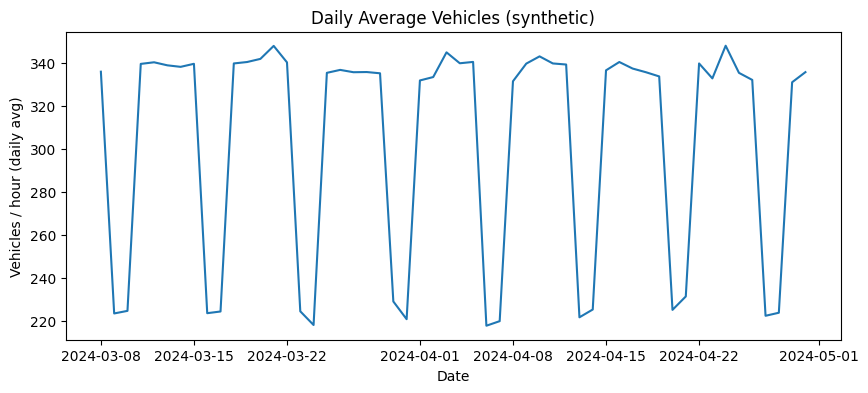

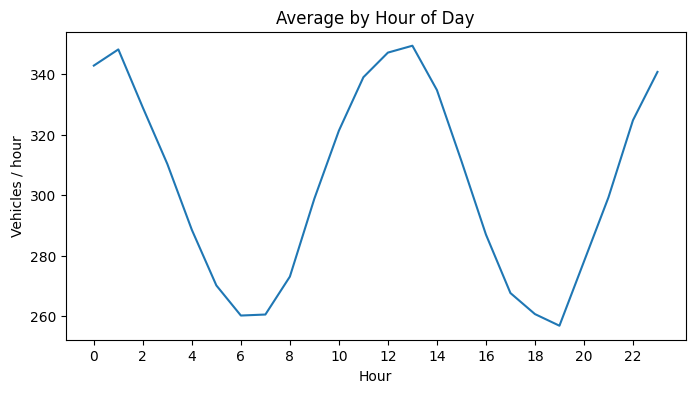

In [126]:

print("Shape:", df_raw.shape)
print(df_raw.head(3))
print("\nMissing values per column:\n", df_raw.isna().sum())

# Plot entire time series (downsampled by day to keep plot readable)
daily = df_raw.set_index("timestamp")["vehicles_count"].resample("D").mean()
plt.figure(figsize=(10,4))
plt.plot(daily.index, daily.values)
plt.title("Daily Average Vehicles (synthetic)")
plt.xlabel("Date")
plt.ylabel("Vehicles / hour (daily avg)")
plt.show()

# Hour-of-day profile
df_raw["hour"] = df_raw["timestamp"].dt.hour
hod = df_raw.groupby("hour")["vehicles_count"].mean().reset_index()
plt.figure(figsize=(8,4))
plt.plot(hod["hour"], hod["vehicles_count"])
plt.title("Average by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Vehicles / hour")
plt.xticks(range(0,24,2))
plt.show()


## 3) Feature Engineering
- Calendar: hour, day_of_week, weekend
- Categorical encoding: weather, is_holiday
- Lag features: t-1, t-2, t-3, t-24 (yesterday), t-168 (last week)

We’ll drop initial rows with NaNs after creating lags.

In [127]:

df = df_raw.copy()
df["day_of_week"] = df["timestamp"].dt.dayofweek
df["is_weekend"] = (df["day_of_week"] >= 5).astype(int)

# One-hot encode simple categoricals
df = pd.get_dummies(df, columns=["weather", "is_holiday"], drop_first=True)

# Create lag features
df = df.sort_values("timestamp").reset_index(drop=True)
for lag in [1,2,3,24,168]:
    df[f"lag_{lag}"] = df["vehicles_count"].shift(lag)

# Drop rows with NA (due to lags)
df = df.dropna().reset_index(drop=True)

feature_cols = [
    "hour","day_of_week","is_weekend",
] + [c for c in df.columns if c.startswith("weather_") or c.startswith("is_holiday_")] + \
  [c for c in df.columns if c.startswith("lag_")]

target_col = "vehicles_count"

print("Feature columns:", feature_cols[:8], "... total:", len(feature_cols))
df[["timestamp","vehicles_count"] + feature_cols[:6]].head()


Feature columns: ['hour', 'day_of_week', 'is_weekend', 'weather_HeavyRain', 'weather_Rain', 'is_holiday_Yes', 'lag_1', 'lag_2'] ... total: 11


,timestamp,vehicles_count,hour,day_of_week,is_weekend,weather_HeavyRain,weather_Rain,is_holiday_Yes
0,2024-03-15 00:00:00,389,0,4,0,False,False,False
1,2024-03-15 01:00:00,369,1,4,0,False,True,False
2,2024-03-15 02:00:00,387,2,4,0,False,False,False
3,2024-03-15 03:00:00,323,3,4,0,False,True,False
4,2024-03-15 04:00:00,333,4,4,0,False,False,False


## 4) Time-aware Train/Test Split
We keep the **last 14 days** for testing to mimic real future predictions.

In [128]:

# Choose last 14 days as test
horizon_days = 14
cutoff = df["timestamp"].max() - pd.Timedelta(days=horizon_days)
train = df[df["timestamp"] <= cutoff].copy()
test  = df[df["timestamp"]  > cutoff].copy()

X_train, y_train = train[feature_cols], train[target_col]
X_test,  y_test  = test[feature_cols],  test[target_col]

train.shape, test.shape


((792, 13), (336, 13))

## 5) Baseline: Seasonal Naïve (last week)
Predict y_t = y_{t-168}. This is a strong baseline for weekly seasonality.

In [129]:

# Baseline needs lag_168 available in test rows (already created)
y_pred_naive = test["lag_168"].values
mae_naive = mean_absolute_error(y_test, y_pred_naive)
mape_naive = np.mean(np.abs((y_test - y_pred_naive) / np.maximum(y_test, 1))) * 100
print(f"Naïve(168) -> MAE={mae_naive:.2f}, MAPE={mape_naive:.2f}%")


Naïve(168) -> MAE=22.99, MAPE=7.94%


## 6) Train Models
We train two simple models and compare:
- **PoissonRegressor** (good for counts)
- **RandomForestRegressor** (nonlinear, robust)


In [130]:

# Poisson GLM
poisson = PoissonRegressor(alpha=1e-4, max_iter=300)
poisson.fit(X_train, y_train)
pred_poisson = poisson.predict(X_test)

# Random Forest
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)

def metrics(y_true, y_hat):
    mae = mean_absolute_error(y_true, y_hat)
    mape = np.mean(np.abs((y_true - y_hat) / np.maximum(y_true, 1))) * 100
    return mae, mape

mae_p, mape_p = metrics(y_test, pred_poisson)
mae_rf, mape_rf = metrics(y_test, pred_rf)

print(f"PoissonRegressor -> MAE={mae_p:.2f}, MAPE={mape_p:.2f}%")
print(f"RandomForest     -> MAE={mae_rf:.2f}, MAPE={mape_rf:.2f}%")
print(f"Naive(168)       -> MAE={mae_naive:.2f}, MAPE={mape_naive:.2f}%")

training_cols = X_train.columns.tolist()


C:\Users\ytian\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_linear_loss.py:330: RuntimeWarning: invalid value encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights


PoissonRegressor -> MAE=52.17, MAPE=19.11%
RandomForest     -> MAE=12.92, MAPE=4.53%
Naive(168)       -> MAE=22.99, MAPE=7.94%


## 7) Plot Predictions vs Actuals (Test Window)

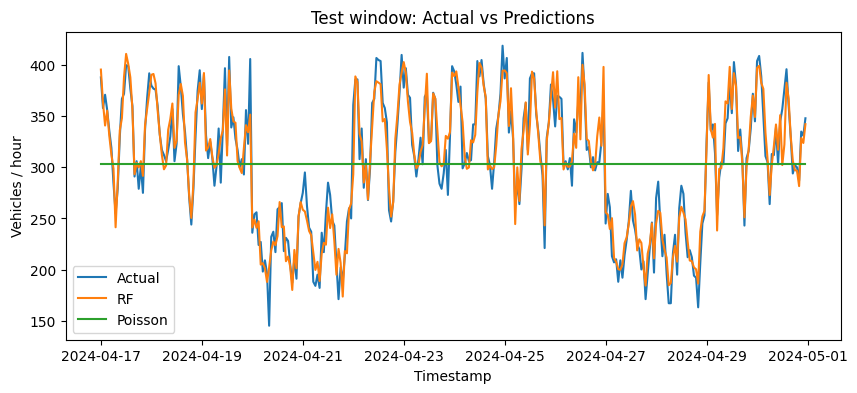

In [131]:
'''
test_plot = test[["timestamp"]].copy()
test_plot["actual"] = y_test.values
test_plot["poisson"] = pred_poisson
test_plot["rf"] = pred_rf
test_plot = test_plot.set_index("timestamp")

'''
test_plot = (pd.DataFrame({
    "timestamp": test["timestamp"].to_numpy(),
    "actual":y_test.to_numpy(),
    "poisson":pred_poisson,
    "rf":pred_rf
    })
    .set_index("timestamp"))

'''
'''
plt.figure(figsize=(10,4))
plt.plot(test_plot.index, test_plot["actual"], label="Actual")
plt.plot(test_plot.index, test_plot["rf"], label="RF")
plt.plot(test_plot.index, test_plot["poisson"], label="Poisson")
plt.title("Test window: Actual vs Predictions")
plt.xlabel("Timestamp")
plt.ylabel("Vehicles / hour")
plt.legend()
plt.show()


In [132]:
import ipykernel, sys
print("ipykernel:", ipykernel.__version__, "python:", sys.version)


ipykernel: 6.30.1 python: 3.13.7 (tags/v3.13.7:bcee1c3, Aug 14 2025, 14:15:11) [MSC v.1944 64 bit (AMD64)]


## 8) Next 24 Hours Forecast (Recursive with Lags)
We’ll forecast the next 24 hours **hour by hour**, feeding each new prediction back as a lag for the following hour.
This uses the **better performing model** between RF and Poisson on the test set.

In [133]:
%pdb on
%xmode verbose


Automatic pdb calling has been turned ON
Exception reporting mode: Verbose


In [134]:
# Choose best model by MAE
best_model = rf if (mean_absolute_error(y_test, pred_rf) <= mean_absolute_error(y_test, pred_poisson)) else poisson

breakpoint()


# Helper to build a single-row feature vector for a future timestamp
def build_feature_row(history_df, current_time):
    row = {}
    row["hour"] = current_time.hour
    row["day_of_week"] = current_time.dayofweek
    row["is_weekend"] = 1 if row["day_of_week"] >= 5 else 0

    # Use default future categoricals (replace with true future covariates if available)
    row["weather_HeavyRain"] = 0
    row["weather_Rain"] = 0
    row["is_holiday_Yes"] = 0

    # Lags from history_df
    last_vals = history_df["vehicles_count"].values
    for lag in [1,2,3,24,168]:
        if len(last_vals) >= lag:
            row[f"lag_{lag}"] = last_vals[-lag]
        else:
            row[f"lag_{lag}"] = last_vals[-1] if len(last_vals)>0 else 0.0

    return pd.DataFrame([row])

# --- NEW: helper to align features to training order ---
def align_to_training(X_like):
    # Prefer model.feature_names_in_ if available; otherwise use saved training_cols
    cols = list(best_model.feature_names_in_) if hasattr(best_model, "feature_names_in_") else list(training_cols)
    # add any missing cols with 0 and order exactly as during fit
    return X_like.reindex(columns=cols, fill_value=0)
    
# Prepare rolling history ending at the last timestamp in df
history = df[["timestamp","vehicles_count"]].copy().sort_values("timestamp").reset_index(drop=True)
last_time = history["timestamp"].iloc[-1]

future_hours = 24
future_times = [last_time + pd.Timedelta(hours=i) for i in range(1, future_hours+1)]

future_preds = []
for t in future_times:
    x_row = build_feature_row(history, t)
    breakpoint()
    for col in feature_cols:
        if col not in x_row.columns:
            x_row[col] = 0
    x_row = x_row[feature_cols]
    y_hat = float(best_model.predict(x_row)[0])
    history = pd.concat([history, pd.DataFrame({"timestamp":[t], "vehicles_count":[y_hat]})], ignore_index=True)
    future_preds.append({"timestamp": t, "pred_mean": y_hat})

future_df = pd.DataFrame(future_preds)
future_df.head()

,timestamp,pred_mean
0,2024-05-01 00:00:00,389.636667
1,2024-05-01 01:00:00,394.316667
2,2024-05-01 02:00:00,385.866667
3,2024-05-01 03:00:00,377.293333
4,2024-05-01 04:00:00,345.503333


### Plot next 24 hours forecast

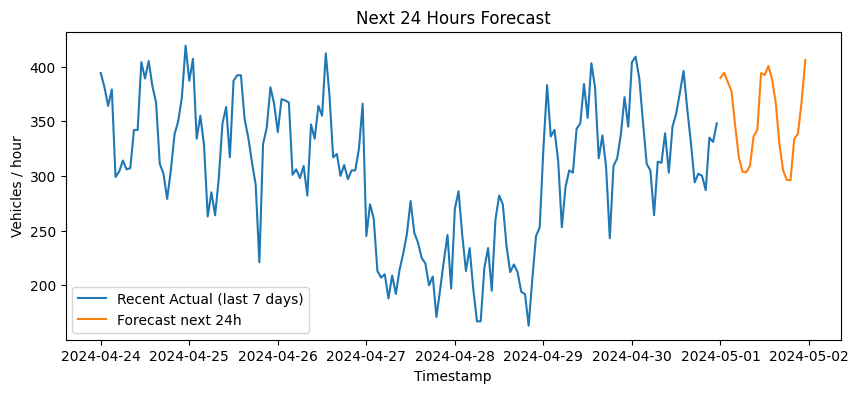

In [135]:

plt.figure(figsize=(10,4))
plt.plot(df["timestamp"].tail(24*7), df["vehicles_count"].tail(24*7), label="Recent Actual (last 7 days)")
plt.plot(future_df["timestamp"], future_df["pred_mean"], label="Forecast next 24h")
plt.title("Next 24 Hours Forecast")
plt.xlabel("Timestamp")
plt.ylabel("Vehicles / hour")
plt.legend()
plt.show()


## 9) Residual-based Anomaly Detection on Test Window
Compute residuals (Actual − Prediction from best model), scale by **MAD** over recent residual history, and flag high-severity points.

In [136]:

# Use best_model predictions on test set
y_hat_test = pred_rf if (mean_absolute_error(y_test, pred_rf) <= mean_absolute_error(y_test, pred_poisson)) else pred_poisson

resid = y_test.values - y_hat_test
resid_series = pd.Series(resid, index=test["timestamp"].values)

def mad(x):
    med = np.median(x)
    return np.median(np.abs(x - med))

window = 24*14  # recent 14 days
recent = resid[-window:] if len(resid) >= window else resid
scale = mad(recent) * 1.4826 if mad(recent) > 0 else (np.std(recent) + 1e-6)
severity = np.abs(resid) / (scale if scale>0 else 1e-6)

threshold = 3.0
flags = severity > threshold

anom_df = pd.DataFrame({
    "timestamp": test["timestamp"].values,
    "actual": y_test.values,
    "pred": y_hat_test,
    "residual": resid,
    "severity": severity,
    "is_anomaly": flags
})

print("Anomalies flagged:", int(anom_df["is_anomaly"].sum()))
anom_df.head()


Anomalies flagged: 7


,timestamp,actual,pred,residual,severity,is_anomaly
0,2024-04-17 00:00:00,388,395.656667,-7.656667,0.481300,False
1,2024-04-17 01:00:00,358,363.263333,-5.263333,0.330855,False
2,2024-04-17 02:00:00,371,340.916667,30.083333,1.891047,False
3,2024-04-17 03:00:00,356,355.466667,0.533333,0.033525,False
4,2024-04-17 04:00:00,336,330.933333,5.066667,0.318492,False


### Plot anomalies (test window)

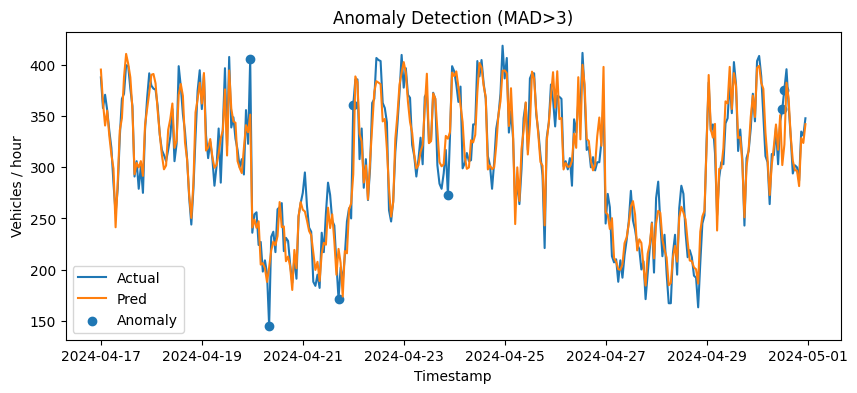

In [137]:

plt.figure(figsize=(10,4))
plt.plot(anom_df["timestamp"], anom_df["actual"], label="Actual")
plt.plot(anom_df["timestamp"], anom_df["pred"], label="Pred")
plt.scatter(anom_df.loc[anom_df["is_anomaly"], "timestamp"],
            anom_df.loc[anom_df["is_anomaly"], "actual"],
            label="Anomaly", marker="o")
plt.title("Anomaly Detection (MAD>3)")
plt.xlabel("Timestamp")
plt.ylabel("Vehicles / hour")
plt.legend()
plt.show()


## 10) Save Outputs
CSV files are written to the current directory for use in dashboards or downstream apps.

In [138]:

out_dir = Path(".")
df.to_csv(out_dir / "hourly_counts_processed.csv", index=False)
future_df.to_csv(out_dir / "forecasts_next24h.csv", index=False)
anom_df.to_csv(out_dir / "anomalies_test_window.csv", index=False)

print("Saved:",
      (out_dir / "hourly_counts_processed.csv").resolve(),
      (out_dir / "forecasts_next24h.csv").resolve(),
      (out_dir / "anomalies_test_window.csv").resolve(),
)


Saved: C:\Users\ytian\second-repo\hourly_counts_processed.csv C:\Users\ytian\second-repo\forecasts_next24h.csv C:\Users\ytian\second-repo\anomalies_test_window.csv


## 11) Swap in Your Real Data
1. Comment out the synthetic generator and **uncomment** the CSV loader at the top.
2. Ensure your columns: `timestamp` (parseable datetime) and `vehicles_count` (integer counts).
3. Optional columns: `weather` (e.g., Clear/Rain/HeavyRain), `is_holiday` (Yes/No). Rename as needed.
4. Rerun the notebook cells — lags and features will be built automatically.

**Tip:** If you have multiple series (e.g., North/South approaches), store `series_id` and repeat per series or train a global model with `series_id` dummies.